# Feature Engineering and Feature Selection

## Inputs

### Libraries

In [2]:
import os

from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd

### Parameters

In [3]:
FILE_URL = "https://drive.google.com/uc?id=1N8eav5HWd6A7rG0ZCRo7rNFryqZS4tVg"
FILE_NAME = "renthop_train.json.gz"
DATA_PATH = "../../data"

### Methods

In [4]:
def download_file_from_gdrive(file_url, filename, out_path: Path, overwrite=False):
    """
    Downloads a file from GDrive given an URL
    :param file_url: a string formated as https://drive.google.com/uc?id=<file_id>
    :param: the desired file name
    :param: the desired folder where the file will be downloaded to
    :param overwrite: whether to overwrite the file if it already exists
    """
    import gdown
    file_exists = os.path.exists(f'{out_path}/{filename}')

    if (file_exists and overwrite) or (not file_exists):
        gdown.download(
            url=file_url,
            output=f'{out_path}/{filename}',
            quiet=True,
        )

## Data

### Download

In [5]:
download_file_from_gdrive(FILE_URL, FILE_NAME, DATA_PATH)

### Read

In [6]:
df = pd.read_json(
    f'{DATA_PATH}/{FILE_NAME}',
    compression="gzip",
    convert_dates=['created']
)

## Feature Extraction

In practice, data rarely comes in the form of ready-to-use matrices. That’s why every task begins with feature extraction. Sometimes, it can be enough to read the csv file and convert it into numpy.array, but this is a rare exception. Let’s look at some of the popular types of data from which features can be extracted.

### Texts

Text is a type of data that can come in different formats; there are so many text processing methods that cannot fit in a single article. Nevertheless, we will review the most popular ones.

Before working with text, one must tokenize it. Tokenization implies splitting the text into units (hence, tokens). Most simply, tokens are just the words. But splitting by word can lose some of the meaning – “Santa Barbara” is one token, not two, but “rock’n’roll” should not be split into two tokens. There are ready-to-use tokenizers that take into account peculiarities of the language, but they make mistakes as well, especially when you work with specific sources of text (newspapers, slang, misspellings, typos).

After tokenization, you will normalize the data. For text, this is about stemming and/or lemmatization; these are similar processes used to process different forms of a word. One can read about the difference between them [here](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).

So, now that we have turned the document into a sequence of words, we can represent it with vectors. The easiest approach is called Bag of Words: we create a vector with the length of the vocabulary, compute the number of occurrences of each word in the text, and place that number of occurrences in the appropriate position in the vector. The process described looks simpler in code:

In [7]:
texts = ["i have a cat", "you have a dog", "you and i have a cat and a dog"]

vocabulary = list(enumerate(set([word for sentence in texts for word in sentence.split()])))
print("Vocabulary:", vocabulary)


def vectorize(text):
    vector = np.zeros(len(vocabulary))
    for i, word in vocabulary:
        num = 0
        for w in text:
            if w == word:
                num += 1
        if num:
            vector[i] = num
    return vector


print("Vectors:")
for sentence in texts:
    print(vectorize(sentence.split()))

Vocabulary: [(0, 'cat'), (1, 'a'), (2, 'dog'), (3, 'you'), (4, 'i'), (5, 'and'), (6, 'have')]
Vectors:
[1. 1. 0. 0. 1. 0. 1.]
[0. 1. 1. 1. 0. 0. 1.]
[1. 2. 1. 1. 1. 2. 1.]


Here is an illustration of the process:

![image](https://mlcourse.ai/_static/img/topic6_bag_of_words.png)

This is an extremely naive implementation. In practice, you need to consider stop words, the maximum length of the vocabulary, more efficient data structures (usually text data is converted to a sparse vector), etc.

When using algorithms like Bag of Words, we lose the order of the words in the text, which means that the texts “i have no cows” and “no, i have cows” will appear identical after vectorization when, in fact, they have the opposite meaning. To avoid this problem, we can revisit our tokenization step and use N-grams (the sequence of N consecutive tokens) instead.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1, 1))
vect.fit_transform(["no i have cows", "i have no cows"]).toarray()

array([[1, 1, 1],
       [1, 1, 1]])

In [9]:
vect.vocabulary_

{'no': 2, 'have': 1, 'cows': 0}

In [10]:
vect = CountVectorizer(ngram_range=(1, 2))
vect.fit_transform(["no i have cows", "i have no cows"]).toarray()

array([[1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 0]])

In [11]:
vect.vocabulary_

{'no': 4,
 'have': 1,
 'cows': 0,
 'no have': 6,
 'have cows': 2,
 'have no': 3,
 'no cows': 5}

Also note that one does not have to use only words. In some cases, it is possible to generate N-grams of characters. This approach would be able to account for similarity of related words or handle typos.

In [12]:
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(3, 3), analyzer="char_wb")

n1, n2, n3, n4 = vect.fit_transform(
    ["andersen", "petersen", "petrov", "smith"]
).toarray()

euclidean(n1, n2), euclidean(n2, n3), euclidean(n3, n4)

(2.8284271247461903, 3.1622776601683795, 3.3166247903554)

Adding onto the Bag of Words idea: words that are rarely found in the corpus (in all the documents of this dataset) but are present in this particular document might be more important. Then it makes sense to increase the weight of more domain-specific words to separate them out from common words. This approach is called TF-IDF (term frequency-inverse document frequency), which cannot be written in a few lines, so you should look into the details in references such as [this wiki](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). The default option is as follows:

$$
    \begin{align*}
        idf\left(t, D \right) &= \log{
            \frac{
                \left|D\right|
            }{
                df(d, t) + 1
            }
        }\\
        tfidf\left(t, d, D \right) &= tf(t, d) \times idf(t, D)
    \end{align*}
$$

Ideas similar to Bag of Words can also be found outside of text problems e.g. bag of sites in the Catch Me If You Can competition, bag of apps, bag of events, etc.

![image](https://mlcourse.ai/_images/topic6_bag_of_words.png)

Using these algorithms, it is possible to obtain a working solution for a simple problem, which can serve as a baseline. However, for those who do not like the classics, there are new approaches. The most popular method in the new wave is Word2Vec, but there are a few alternatives as well (GloVe, Fasttext, etc.).

Word2Vec is a special case of the word embedding algorithms. Using Word2Vec and similar models, we can not only vectorize words in a high-dimensional space (typically a few hundred dimensions) but also compare their semantic similarity. This is a classic example of operations that can be performed on vectorized concepts: `king - man + woman = queen`.

![img](https://cdn-images-1.medium.com/max/800/1*K5X4N-MJKt8FGFtrTHwidg.gif)

It is worth noting that this model does not comprehend the meaning of the words but simply tries to position the vectors such that words used in common context are close to each other. If this is not taken into account, a lot of fun examples will come up.

Such models need to be trained on very large datasets in order for the vector coordinates to capture the semantics. A pretrained model for your own tasks can be downloaded here.

Similar methods are applied in other areas such as bioinformatics. An unexpected application is food2vec. You can probably think of a few other fresh ideas; the concept is universal enough.

### Images

Working with images is easier and harder at the same time. It is easier because it is possible to just use one of the popular pretrained networks without much thinking but harder because, if you need to dig into the details, you may end up going really deep. Let’s start from the beginning.

In a time when GPUs were weaker and the “renaissance of neural networks” had not happened yet, feature generation from images was its own complex field. One had to work at a low level, determining corners, borders of regions, color distributions statistics, and so on. Experienced specialists in computer vision could draw a lot of parallels between older approaches and neural networks; in particular, convolutional layers in today’s networks are similar to Haar cascades. If you are interested in reading more, here are a couple of links to some interesting libraries: skimage and SimpleCV.

Often for problems associated with images, a convolutional neural network is used. You do not have to come up with the architecture and train a network from scratch. Instead, download a pretrained state-of-the-art network with the weights from public sources. Data scientists often do so-called fine-tuning to adapt these networks to their needs by “detaching” the last fully connected layers of the network, adding new layers chosen for a specific task, and then training the network on new data. If your task is to just vectorize the image (for example, to use some non-network classifier), you only need to remove the last layers and use the output from the previous layers:

In [13]:
# # Install Keras and tensorflow (https://keras.io/)
# from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.preprocessing import image
# from scipy.misc import face
# import numpy as np

# resnet_settings = {'include_top': False, 'weights': 'imagenet'}
# resnet = ResNet50(**resnet_settings)

# # What a cute raccoon!
# img = image.array_to_img(face())
# img

In [14]:
# # In real life, you may need to pay more attention to resizing
# img = img.resize((224, 224))

# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# # Need an extra dimension because model is designed to work with an array
# # of images - i.e. tensor shaped (batch_size, width, height, n_channels)

# features = resnet.predict(x)

![img](https://cdn-images-1.medium.com/max/800/1*Iw_cKFwLkTVO2SPrOZU2rQ.png)

Here’s a classifier trained on one dataset and adapted for a different one by “detaching” the last layer and adding a new one instead.

Nevertheless, we should not focus too much on neural network techniques. Features generated by hand are still very useful: for example, for predicting the popularity of a rental listing, we can assume that bright apartments attract more attention and create a feature such as “the average value of the pixel”. You can find some inspiring examples in the documentation of relevant libraries.

If there is text on the image, you can read it without unraveling a complicated neural network. For example, check out pytesseract.

In [15]:
##### requires `tesseract` to be installed in the system
# import pytesseract
# from PIL import Image
# import requests
# from io import BytesIO

##### Just a random picture from search
# img = "http://ohscurrent.org/wp-content/uploads/2015/09/domus-01-google.jpg"
# img = requests.get(img)
# img = Image.open(BytesIO(img.content))
# text = pytesseract.image_to_string(img)

# print(text)

It’s good to keep in mind that pytesseract is not a “silver bullet”.
![img](https://mlcourse.ai/_images/topic6_apartment_plan.jpg)

In [16]:
#img = "https://habrastorage.org/webt/mj/uv/6o/mjuv6olsh1x9xxe1a6zjy79u1w8.jpeg"
#img = requests.get(img)
#img = Image.open(BytesIO(img.content))

#print(pytesseract.image_to_string(img))

Another case where neural networks cannot help is extracting features from meta-information. For images, EXIF stores many useful meta-information: manufacturer and camera model, resolution, use of the flash, geographic coordinates of shooting, software used to process image and more.

### Geospatial data

Geographic data is not so often found in problems, but it is still useful to master the basic techniques for working with it, especially since there are quite a number of ready-to-use solutions in this field.

Geospatial data is often presented in the form of addresses or coordinates of (Latitude, Longitude). Depending on the task, you may need two mutually-inverse operations: geocoding (recovering a point from an address) and reverse geocoding (recovering an address from a point). Both operations are accessible in practice via external APIs from Google Maps or OpenStreetMap. Different geocoders have their own characteristics, and the quality varies from region to region. Fortunately, there are universal libraries like geopy that act as wrappers for these external services.

If you have a lot of data, you will quickly reach the limits of external API. Besides, it is not always the fastest to receive information via HTTP. Therefore, it is necessary to consider using a local version of OpenStreetMap.

If you have a small amount of data, enough time, and no desire to extract fancy features, you can use reverse_geocoder in lieu of OpenStreetMap:

## Feature transformations

### Normalization and changing distribution

Monotonic feature transformation is critical for some algorithms and has no effect on others. This is one of the reasons for the increased popularity of decision trees and all its derivative algorithms (random forest, gradient boosting). Not everyone can or want to tinker with transformations, and these algorithms are robust to unusual distributions.

There are also purely engineering reasons: np.log is a way of dealing with large numbers that do not fit in np.float64. This is an exception rather than a rule; often it’s driven by the desire to adapt the dataset to the requirements of the algorithm. Parametric methods usually require the data distribution to be at least symmetric and unimodal, which is not always the case. There may be more stringent requirements; recall our earlier article about linear models.

However, data requirements are imposed not only by parametric methods; K nearest neighbors will predict complete nonsense if features are not normalized e.g. when one distribution is located in the vicinity of zero and does not go beyond (-1, 1) while the other’s range is on the order of hundreds of thousands.

A simple example: suppose that the task is to predict the cost of an apartment from two variables — the distance from city center and the number of rooms. The number of rooms rarely exceeds 5 whereas the distance from city center can easily be in the thousands of meters.

The simplest transformation is Standard Scaling (or Z-score normalization):

$$
    z = \frac{
        x - \mu
    }{
        \sigma
    }
$$

Note that Standard Scaling does not make the distribution normal in the strict sense.

In [17]:
import numpy as np
from scipy.stats import beta, shapiro
from sklearn.preprocessing import StandardScaler

data = beta(1, 10).rvs(1000).reshape(-1, 1)
shapiro(data)

ShapiroResult(statistic=0.8601082271488969, pvalue=6.694528297663463e-29)

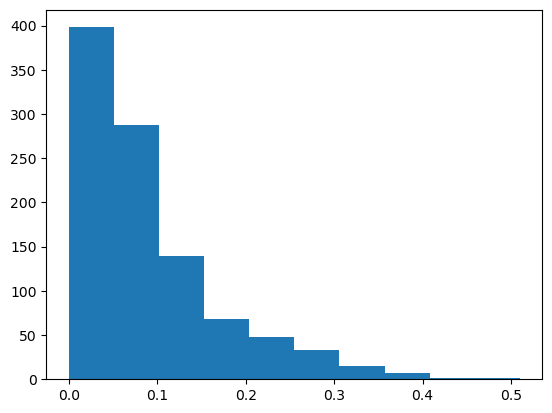

In [22]:
import matplotlib.pyplot as plt

plt.hist(data)
plt.show()

In [23]:
# Value of the statistic, p-value
shapiro(StandardScaler().fit_transform(data))

# With such p-value we'd have to reject the null hypothesis of normality of the data

ShapiroResult(statistic=0.8601082271488969, pvalue=6.694528297663463e-29)

But, to some extent, it protects against outliers:

(array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.42457141, -0.06639914,  0.29177313,  0.6499454 ,  1.00811767,
         1.36628994,  1.72446221,  2.08263447,  2.44080674,  2.79897901,
         3.15715128]),
 <BarContainer object of 10 artists>)

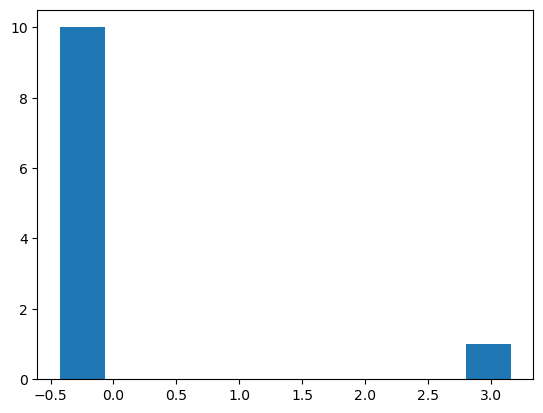

In [25]:
data = np.array([1, 1, 0, -1, 2, 1, 2, 3, -2, 4, 100]).reshape(-1, 1).astype(np.float64)
StandardScaler().fit_transform(data)
plt.hist(StandardScaler().fit_transform(data))

Another fairly popular option is MinMax Scaling, which brings all the points within a predetermined interval (typically (0, 1))

$$
    X_{\text{norm}} = \frac{
        X - X_{\text{min}}
    }{
        X_{\text{max}} -X _{\text{min}}
    }
$$

In [26]:
shapiro(StandardScaler().fit_transform(data))

ShapiroResult(statistic=0.39913510282632503, pvalue=9.586522425393625e-08)

In [27]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler().fit_transform(data)

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

(array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

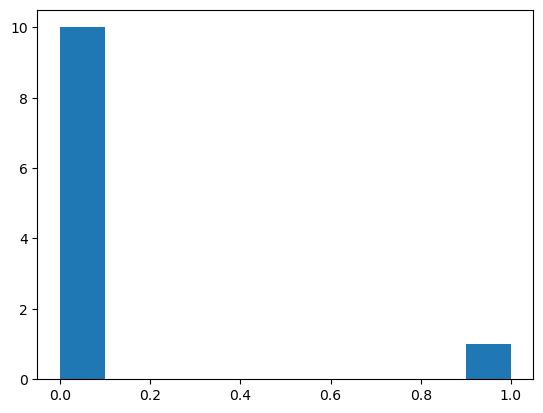

In [29]:
plt.hist(MinMaxScaler().fit_transform(data))

StandardScaling and MinMax Scaling have similar applications and are often more or less interchangeable. However, if the algorithm involves the calculation of distances between points or vectors, the default choice is StandardScaling. But MinMax Scaling is useful for visualization by bringing features within the interval (0, 255).

If we assume that some data is not normally distributed but is described by the log-normal distribution, it can easily be transformed to a normal distribution:

In [30]:
from scipy.stats import lognorm

data = lognorm(s=1).rvs(1000)
shapiro(data)

ShapiroResult(statistic=0.5472918285855173, pvalue=7.531853425438159e-45)

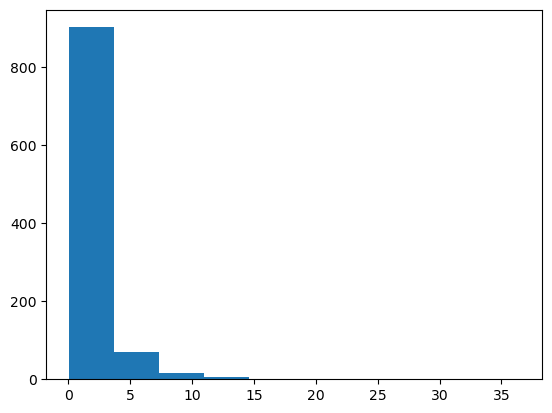

In [31]:
plt.hist(data)
plt.show()

In [32]:
shapiro(np.log(data))

ShapiroResult(statistic=0.9994291783093755, pvalue=0.994296195627579)

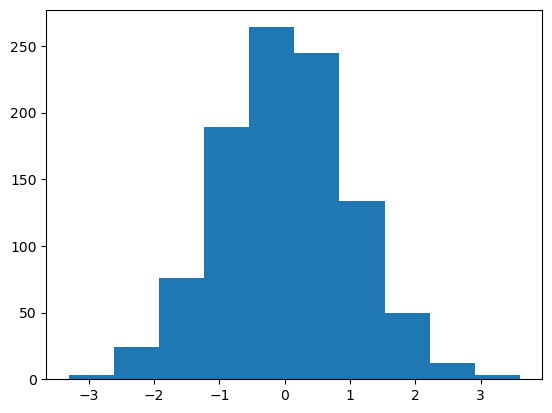

In [33]:
plt.hist(np.log(data))
plt.show()

The lognormal distribution is suitable for describing salaries, price of securities, urban population, number of comments on articles on the internet, etc. However, to apply this procedure, the underlying distribution does not necessarily have to be lognormal; you can try to apply this transformation to any distribution with a heavy right tail. Furthermore, one can try to use other similar transformations, formulating their own hypotheses on how to approximate the available distribution to a normal. Examples of such transformations are Box-Cox transformation (logarithm is a special case of the Box-Cox transformation) or Yeo-Johnson transformation (extends the range of applicability to negative numbers). In addition, you can also try adding a constant to the feature — `np.log (x + const)`.

In the examples above, we have worked with synthetic data and strictly tested normality using the Shapiro-Wilk test. Let’s try to look at some real data and test for normality using a less formal method — Q-Q plot. For a normal distribution, it will look like a smooth diagonal line, and visual anomalies should be intuitively understandable.

![img](https://mlcourse.ai/_images/topic6_qq_lognorm.png)

![img](https://mlcourse.ai/_images/topic6_qq_log.png)

In [34]:
# Let's draw plots!
import statsmodels.api as sm

# Let's take the price feature from Renthop dataset and filter by hands the most extreme values for clarity

price = df.price[(df.price <= 20000) & (df.price > 500)]
price_log = np.log(price)

# A lot of gestures so that sklearn didn't shower us with warnings
price_mm = (
    MinMaxScaler()
    .fit_transform(price.values.reshape(-1, 1).astype(np.float64))
    .flatten()
)
price_z = (
    StandardScaler()
    .fit_transform(price.values.reshape(-1, 1).astype(np.float64))
    .flatten()
)

Q-Q plot of the initial feature

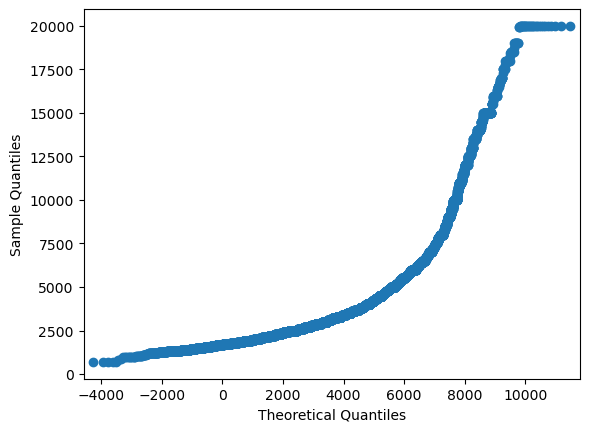

In [40]:
sm.qqplot(price, loc=price.mean(), scale=price.std())
plt.show()

Q-Q plot after StandardScaler. Shape doesn’t change

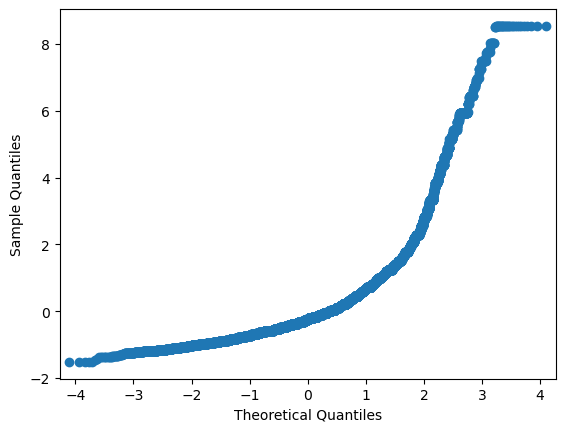

In [41]:
sm.qqplot(price_z, loc=price_z.mean(), scale=price_z.std())
plt.show()

Q-Q plot after MinMaxScaler. Shape doesn’t change

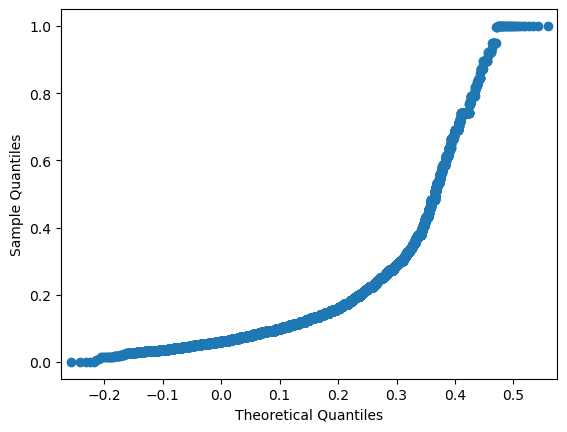

In [46]:
sm.qqplot(price_mm, loc=price_mm.mean(), scale=price_mm.std())
plt.show()

Q-Q plot after taking the logarithm. Things are getting better!

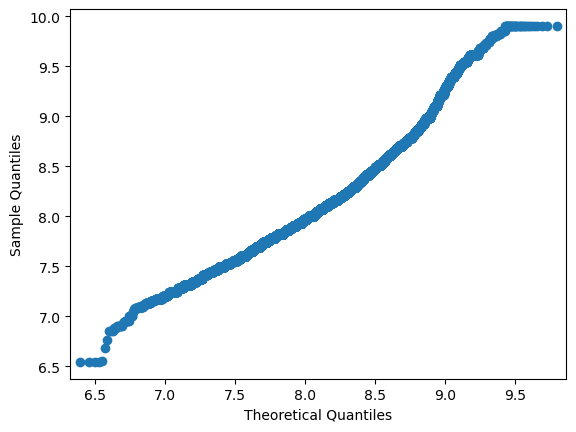

In [47]:
sm.qqplot(price_log, loc=price_log.mean(), scale=price_log.std())
plt.show()

Let’s see whether transformations can somehow help the real model. There is no silver bullet here.

### Interactions

If previous transformations seemed rather math-driven, this part is more about the nature of the data; it can be attributed to both feature transformations and feature creation.

Let’s come back again to the Two Sigma Connect: Rental Listing Inquiries problem. Among the features in this problem are the number of rooms and the price. Logic suggests that the cost per single room is more indicative than the total cost, so we can generate such a feature.

In [50]:
rooms = df["bedrooms"].apply(lambda x: max(x, 0.5))
# Avoid division by zero; .5 is chosen more or less arbitrarily
df["price_per_bedroom"] = df["price"] / rooms

You should limit yourself in this process. If there are a limited number of features, it is possible to generate all the possible interactions and then weed out the unnecessary ones using the techniques described in the next section. In addition, not all interactions between features must have a physical meaning; for example, polynomial features (see sklearn.preprocessing.PolynomialFeatures) are often used in linear models and are almost impossible to interpret.

### Filling in the missing values

Not many algorithms can work with missing values, and the real world often provides data with gaps. Fortunately, this is one of the tasks for which one doesn’t need any creativity. Both key python libraries for data analysis provide easy-to-use solutions: pandas.DataFrame.fillna and sklearn.preprocessing.Imputer.

These solutions do not have any magic happening behind the scenes. Approaches to handling missing values are pretty straightforward:

- encode missing values with a separate blank value like "n/a" (for categorical variables);
- use the most probable value of the feature (mean or median for the numerical variables, the most common value for categorical variables);
- or, conversely, encode with some extreme value (good for decision-tree models since it allows the model to make a partition between the missing and non-missing values);
- for ordered data (e.g. time series), take the adjacent value — next or previous.

![img](https://cdn-images-1.medium.com/max/800/0*Ps-v8F0fBgmnG36S.)

Easy-to-use library solutions sometimes suggest sticking to something like `df = df.fillna(0)` and not sweat the gaps. But this is not the best solution: data preparation takes more time than building models, so thoughtless gap-filling may hide a bug in processing and damage the model.

## Feature selection

Why would it even be necessary to select features? To some, this idea may seem counterintuitive, but there are at least two important reasons to get rid of unimportant features. The first is clear to every engineer: the more data, the higher the computational complexity. As long as we work with toy datasets, the size of the data is not a problem, but, for real loaded production systems, hundreds of extra features will be quite tangible. The second reason is that some algorithms take noise (non-informative features) as a signal and overfit.

In [55]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import VarianceThreshold

x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

In [57]:
VarianceThreshold?

Init signature: VarianceThreshold(threshold=0.0)
Docstring:     
Feature selector that removes all low-variance features.

This feature selection algorithm looks only at the features (X), not the
desired outputs (y), and can thus be used for unsupervised learning.

Read more in the :ref:`User Guide <variance_threshold>`.

Parameters
----------
threshold : float, default=0
    Features with a training-set variance lower than this threshold will
    be removed. The default is to keep all features with non-zero variance,
    i.e. remove the features that have the same value in all samples.

Attributes
----------
variances_ : array, shape (n_features,)
    Variances of individual features.

n_features_in_ : int
    Number of features seen during :term:`fit`.

    .. versionadded:: 0.24

feature_names_in_ : ndarray of shape (`n_features_in_`,)
    Names of features seen during :term:`fit`. Defined only when `X`
    has feature names that are all strings.

    .. versionadded:: 1.0

See Also

In [56]:
VarianceThreshold(0.7).fit_transform(x_data_generated).shape

(100, 20)

In [58]:
VarianceThreshold(0.8).fit_transform(x_data_generated).shape

(100, 19)

In [59]:
VarianceThreshold(0.9).fit_transform(x_data_generated).shape

(100, 18)

There are other ways that are also [based on classical statistics](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [60]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)
x_data_varth = VarianceThreshold(0.9).fit_transform(x_data_generated)

In [61]:
logit = LogisticRegression(solver="lbfgs", random_state=17)

In [62]:
cross_val_score(
    logit, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
).mean()

-0.3366777387095648

In [63]:
cross_val_score(
    logit, x_data_kbest, y_data_generated, scoring="neg_log_loss", cv=5
).mean()

-0.2220685660825111

In [64]:
cross_val_score(
    logit, x_data_varth, y_data_generated, scoring="neg_log_loss", cv=5
).mean()

-0.31756115798992957

We can see that our selected features have improved the quality of the classifier. Of course, this example is purely artificial; however, it is worth using for real problems.

### Selection by modeling

Another approach is to use some baseline model for feature evaluation because the model will clearly show the importance of the features. Two types of models are usually used: some “wooden” composition such as Random Forest or a linear model with Lasso regularization so that it is prone to nullify weights of weak features. The logic is intuitive: if features are clearly useless in a simple model, there is no need to drag them to a more complex one.

In [65]:
# Synthetic example

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()

rf = RandomForestClassifier(n_estimators=10, random_state=17)
pipe = make_pipeline(SelectFromModel(estimator=rf), logit)

print(
    cross_val_score(
        logit, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
    ).mean()
)
print(
    cross_val_score(
        rf, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
    ).mean()
)
print(
    cross_val_score(
        pipe, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
    ).mean()
)

-0.416383473700823
-0.4255526302648757
-0.4127662809099498


We must not forget that this is not a silver bullet again - it can make the performance worse.

In [66]:
# x_data, y_data = get_data()
x_data = x_data_generated
y_data = y_data_generated

pipe1 = make_pipeline(StandardScaler(), SelectFromModel(estimator=rf), logit)

pipe2 = make_pipeline(StandardScaler(), logit)

print(
    "LR + selection: ",
    cross_val_score(pipe1, x_data, y_data, scoring="neg_log_loss", cv=5).mean(),
)
print(
    "LR: ", cross_val_score(pipe2, x_data, y_data, scoring="neg_log_loss", cv=5).mean()
)
print("RF: ", cross_val_score(rf, x_data, y_data, scoring="neg_log_loss", cv=5).mean())

LR + selection:  -0.4150845754442569
LR:  -0.4199257626532029
RF:  -0.4255526302648757


### Grid search

Finally, we get to the most reliable method, which is also the most computationally complex: trivial grid search. Train a model on a subset of features, store results, repeat for different subsets, and compare the quality of models to identify the best feature set. This approach is called Exhaustive Feature Selection.

Searching all combinations usually takes too long, so you can try to reduce the search space. Fix a small number `N`, iterate through all combinations of `N` features, choose the best combination, and then iterate through the combinations of `(N + 1)` features so that the previous best combination of features is fixed and only a single new feature is considered. It is possible to iterate until we hit a maximum number of characteristics or until the quality of the model ceases to increase significantly. This algorithm is called Sequential Feature Selection.

This algorithm can be reversed: start with the complete feature space and remove features one by one until it does not impair the quality of the model or until the desired number of features is reached.

In [ ]:
# # Install mlxtend
# from mlxtend.feature_selection import SequentialFeatureSelector

# selector = SequentialFeatureSelector(
#     logit, scoring="neg_log_loss", verbose=2, k_features=3, forward=False, n_jobs=-1
# )

# selector.fit(x_data, y_data)

Take a look how this approach was done in one [simple yet elegant Kaggle kernel](https://www.kaggle.com/arsenyinfo/easy-feature-selection-pipeline-0-55-at-lb).